# Libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import Callback
import numpy as np


from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error

Plot of the variables: High, Low, Close

/tmp/ipykernel_140027/3733988950.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


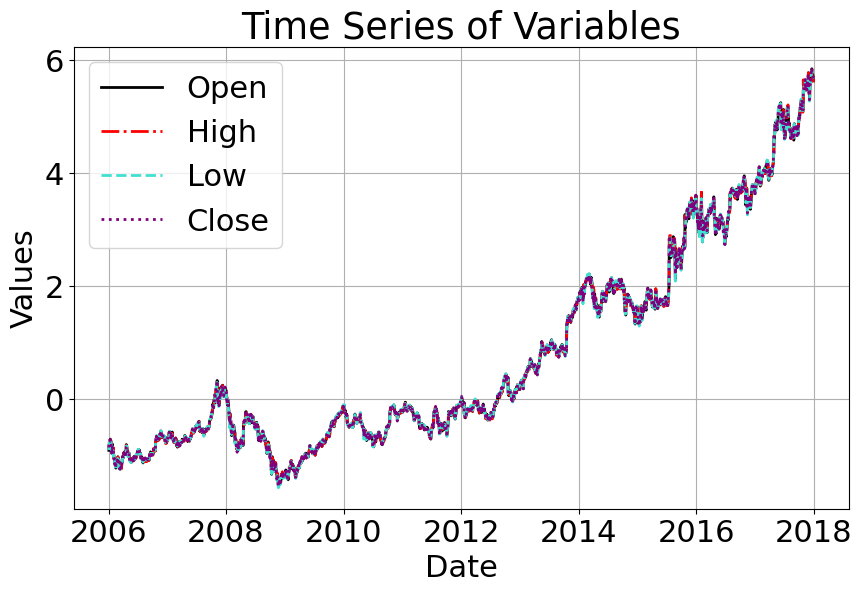

In [20]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')



#Normalize
train_ratio = 0.8
val_ratio = 0.1
train_end_idx = int(data.shape[0] * train_ratio)
val_end_idx = int(data.shape[0] * (train_ratio + val_ratio))

scaler = StandardScaler()
data.iloc[:train_end_idx] = scaler.fit_transform(data.iloc[:train_end_idx])
data.iloc[train_end_idx:] = scaler.transform(data.iloc[train_end_idx:])




Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

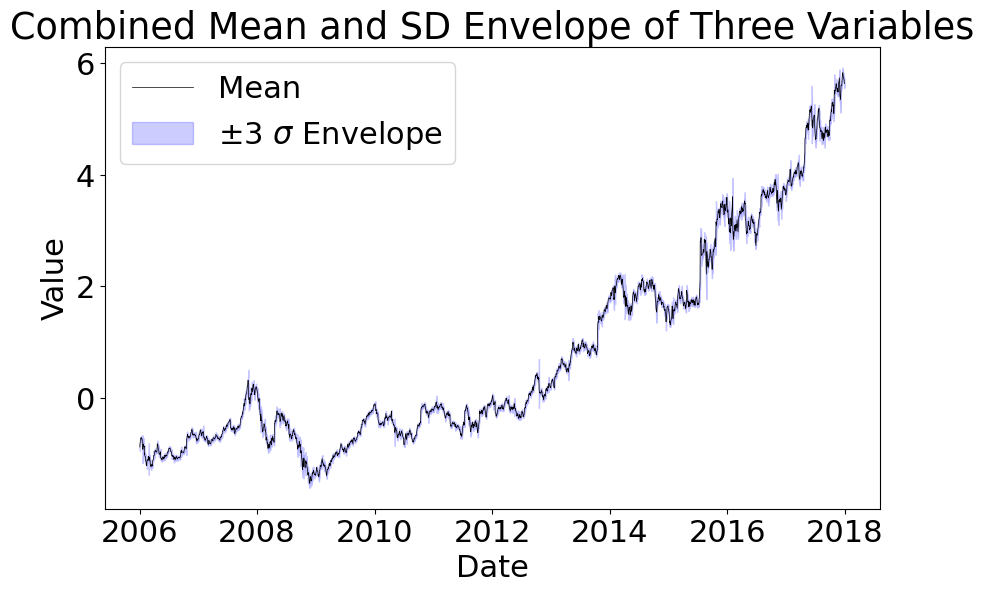

In [3]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,
    mean_all + 3*std_dev_all,
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

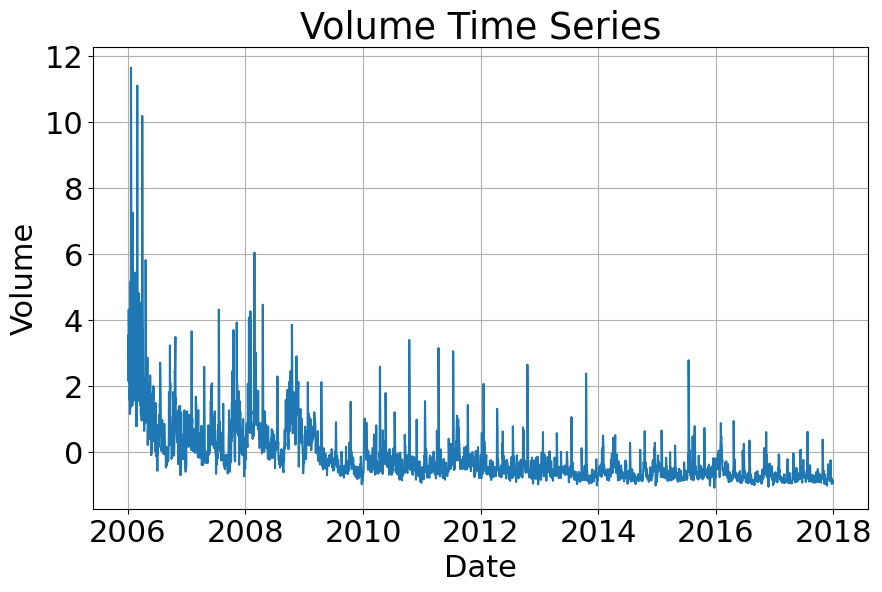

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Series')
plt.grid(True)
plt.savefig("Volume Time Series.png")
plt.show()

Seasonal Trent decomposition using LOESS (STL)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")


Seasonal Trend Decomposition


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

cases=["Open","High","Low","Close", "Volume"]
results={}
for cs in cases:
    data[cs] = data[cs].fillna(method='ffill')
    data[cs].index = pd.to_datetime(data.index)
    data[cs] = data[cs].asfreq('B')

    # daily seasonality
    result = seasonal_decompose(data[cs], model='multiplicative', period=365)
    results[cs]=result
    result.plot()
    plt.show()
    plt.savefig("TSDec_"+cs+".png")


/tmp/ipykernel_27081/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

Volume traded per price graph

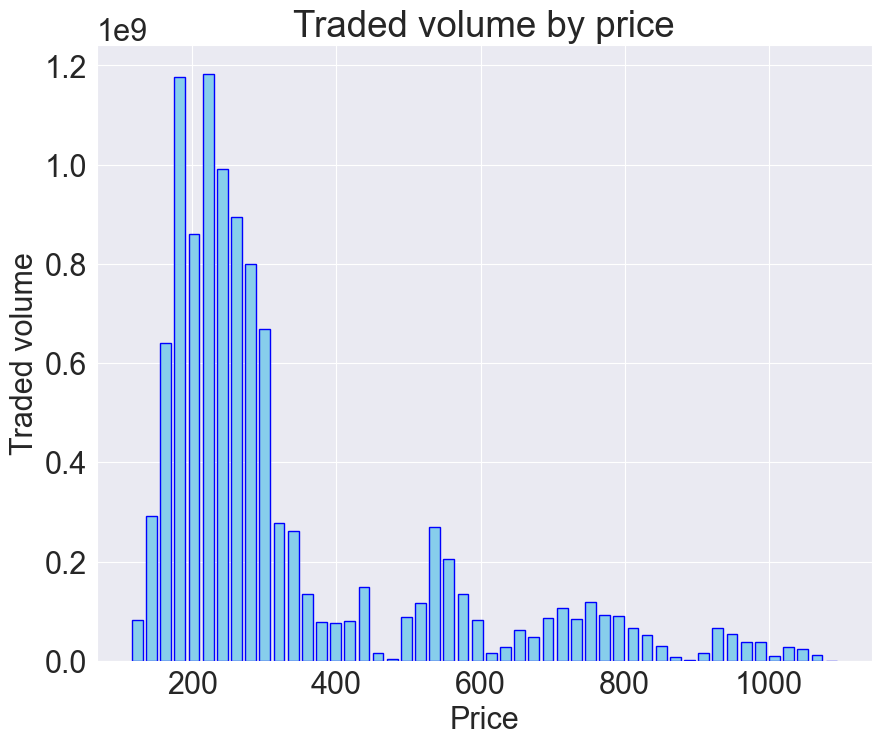

In [ ]:
import numpy as np

num_bins = 50 # Number of bins

# Define price bins based on high and low price
price_min = data['Low'].min()
price_max = data['High'].max()
bins = np.linspace(price_min, price_max, num_bins)

# Calculate the midpoints of the bins for plotting

# Calculate the volume in each price bin
volume_by_price = np.zeros(len(bins))

for i in range(len(bins)-1):
    mask = (Close >= bins[i]) & (Close < bins[i + 1])
    volume_by_price[i] = Volume[mask].sum()

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Create a horizontal bar chart for volume by price
ax.bar(bins, volume_by_price, align='center', color='skyblue', edgecolor='blue', width=15)
ax.set_xlabel('Price')
ax.set_ylabel('Traded volume')
ax.set_title('Traded volume by price')
plt.savefig("Traded volume by price.png")
plt.show()

Autocorrelation analysis

            0        1        2        3           4
0      211.47   218.05   209.32   217.83  13137450.0
1      222.17   224.70   220.09   222.84  15292353.0
2      223.22   226.00   220.97   225.85  10815661.0
3      228.66   235.49   226.85   233.06  17759521.0
4      233.44   236.94   230.70   233.68  12795837.0
...       ...      ...      ...      ...         ...
3014  1070.00  1071.72  1067.64  1068.86    889446.0
3015  1068.64  1068.86  1058.64  1065.85    918767.0
3016  1066.60  1068.27  1058.38  1060.20   1116203.0
3017  1062.25  1064.84  1053.38  1055.95    994249.0
3018  1055.49  1058.05  1052.70  1053.40   1180340.0

[3019 rows x 5 columns]
          0         1         2         3         4
0  1.000000  0.999894  0.999841  0.999742 -0.443155
1  0.999894  1.000000  0.999827  0.999866 -0.440717
2  0.999841  0.999827  1.000000  0.999896 -0.447781
3  0.999742  0.999866  0.999896  1.000000 -0.444590
4 -0.443155 -0.440717 -0.447781 -0.444590  1.000000


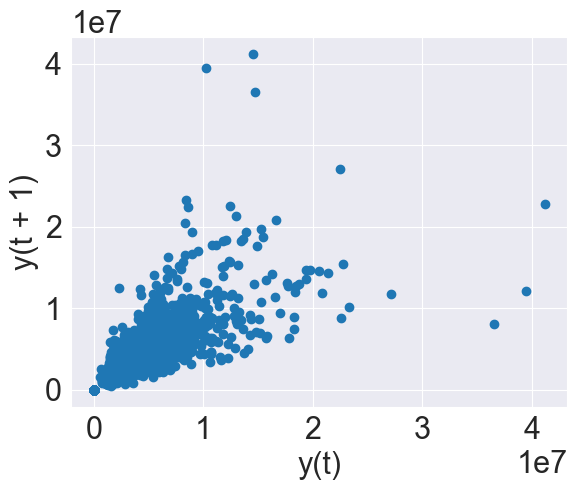

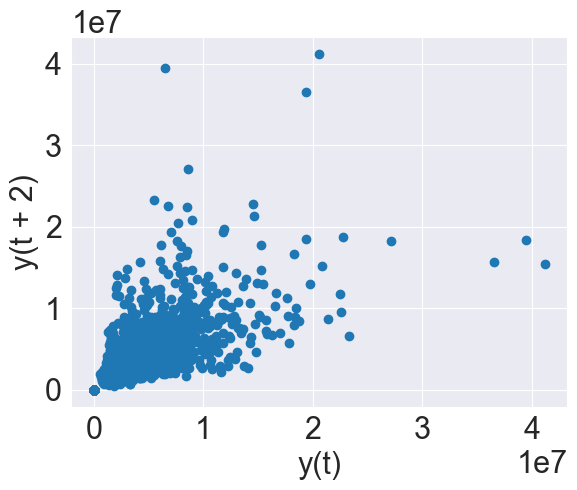

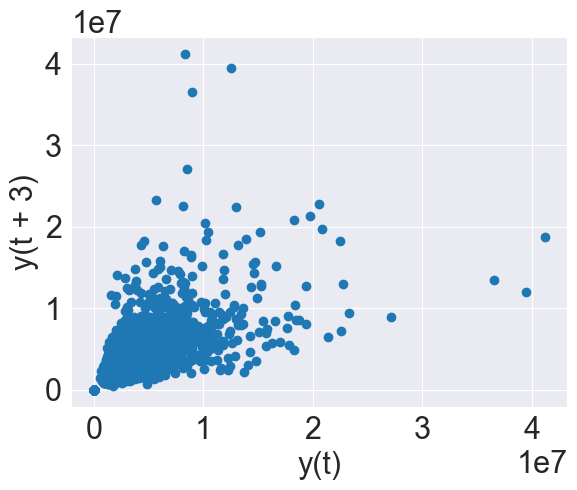

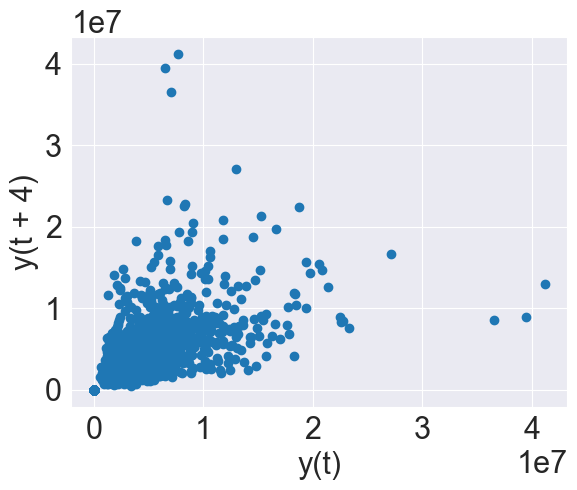

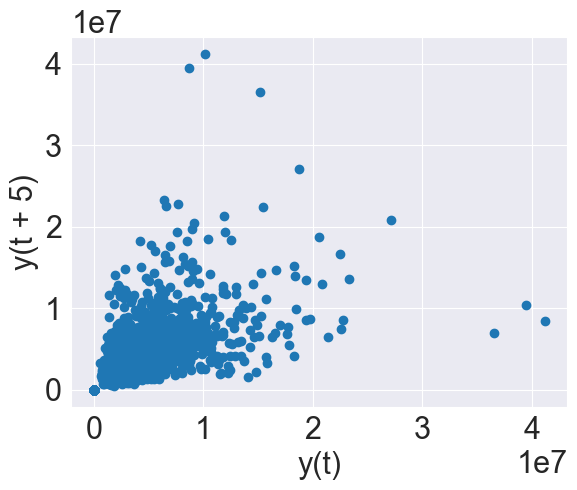

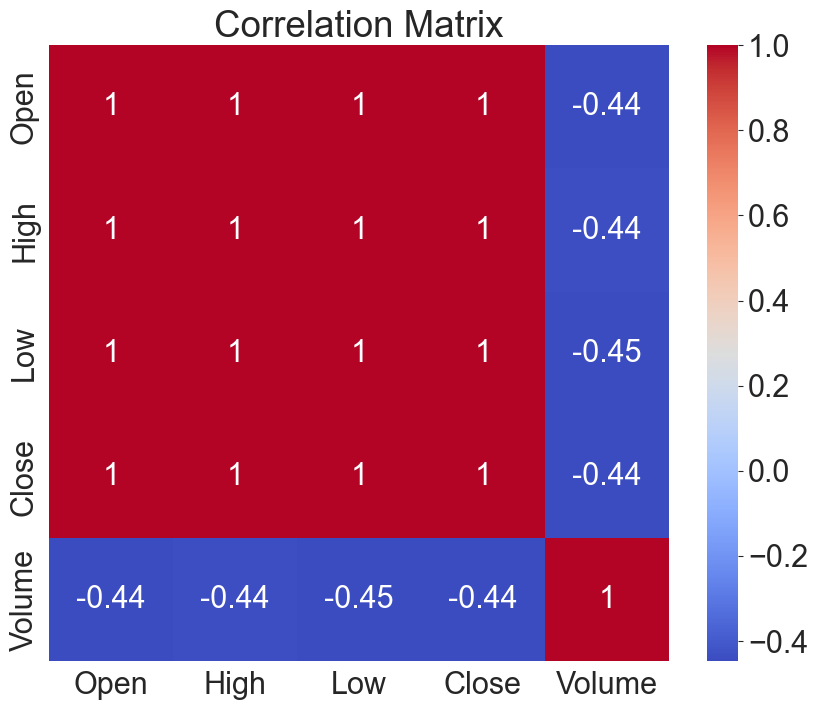

<Figure size 640x480 with 0 Axes>

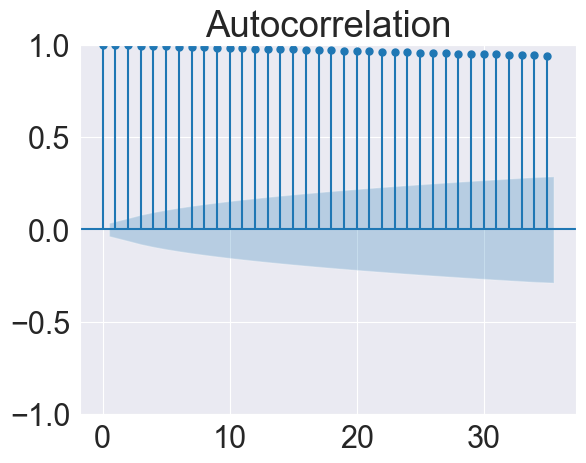

<Figure size 640x480 with 0 Axes>

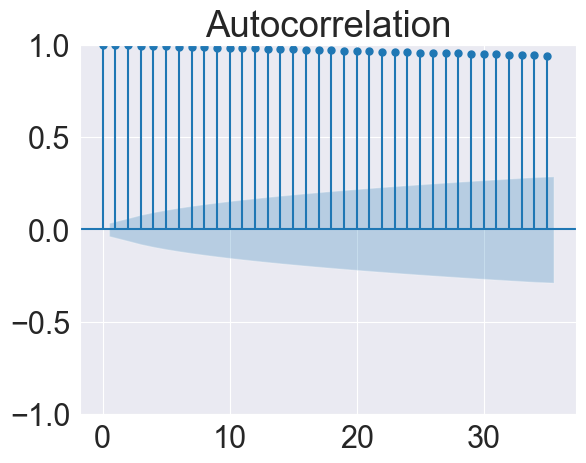

<Figure size 640x480 with 0 Axes>

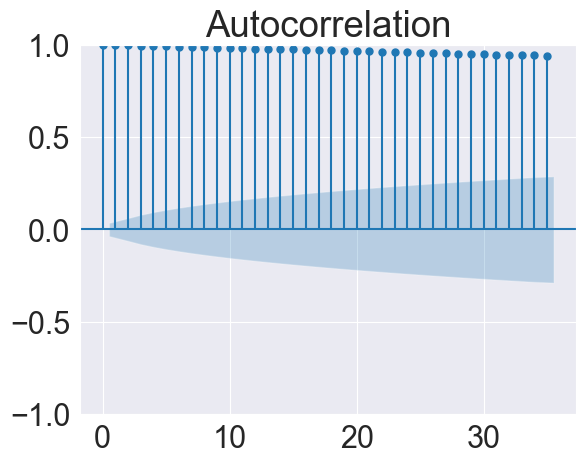

<Figure size 640x480 with 0 Axes>

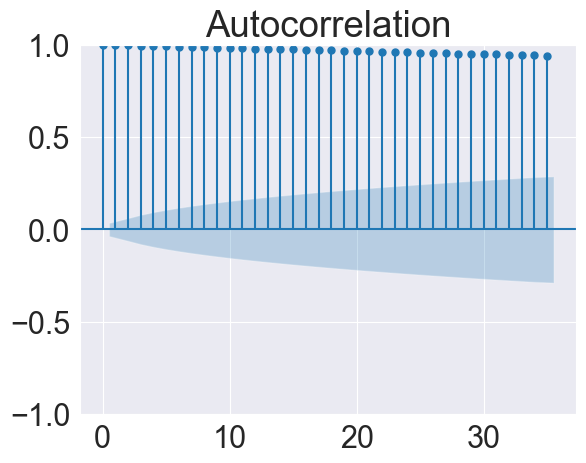

<Figure size 640x480 with 0 Axes>

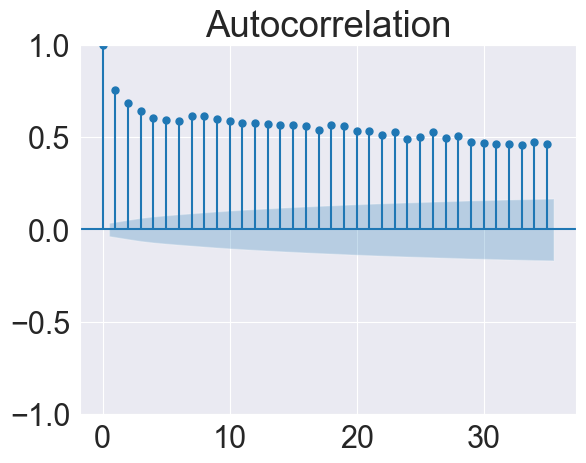

In [ ]:
# lagplot
for i in range(5):
    plt.figure()
    pd.plotting.lag_plot(data, lag=i+1)
    #plt.title("Lag plot of variable '" + data.columns[i]  + "'")
    plt.savefig("Lag_plot_" + str(i) + ".png")

# extracting only the temperature values
values = pd.DataFrame(data.values)
print(values)

# Create correlation matrix
correlation_matrix = values.corr()

# Print the correlation matrix
print(correlation_matrix)

# Optionally, plot the correlation matrix for better visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=data.columns, yticklabels=data.columns)
plt.title("Correlation Matrix")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

for i in range(5):
    plt.figure()
    plot_acf(data.iloc[:, i])
    #plt.title("Autocorrelation of variable '" + data.columns[i]  + "'")
    plt.title("")
    plt.savefig("auc_" + str(i) + ".png")



$\mathbb{Autoregressive \quad part}$

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
cases=["Open", "Close", "Low", "High", "Volume"]
rmse_residuals={}
for cs in cases:
  series=data[cs] # change with close, Min, Max, Volume
  T = 10 # we should find a T that creates decets results.
  X = []
  Y = []
  rmse_residuals[cs]={}

  for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

  X = np.array(X).reshape(-1, T)
  Y = np.array(Y)
  N = len(X)
  print("X.shape", X.shape, "Y.shape", Y.shape)


  # Try autoregressive model
  i = Input(shape=(T,))
  x = Dense(1)(i)
  model = Model(i, x)
  model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1)
  )

  # train
  r = model.fit(
      X[:-N//2], Y[:-N//2],
      epochs=80,
      validation_data=(X[-N//2:], Y[-N//2:]),
  )

  # Plot loss per iteration
  plt.plot(r.history["loss"], label="Training Loss")
  plt.plot(r.history["val_loss"], label="Validation loss")
  plt.legend()
  plt.savefig("Loss_per_iteration_"+cs+".png")
  plt.close()

  # Forecast future values
  validation_target = Y[-int(N*0.2):] # use as validation only the last 20% of the data
  validation_predictions = []

  # Last train input
  last_x = X[-int(N*0.2)]

  while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0, 0] # 1x1 array

    # Update predictions list
    validation_predictions.append(p)

    # Make the new input
    last_x = np.roll(last_x, -1) # shift everything one spot to the left, we replace it with the latest forecasted prediction. Multi-step predictions.
    last_x[-1] = p

  plt.plot(validation_target, label="forecast_target")
  plt.plot(validation_predictions, label="forecast_prediction")
  plt.legend()
  plt.savefig("forecast_target_vs_prediction_"+cs+".png")
  plt.close()

  # Compare rmse of the model and the mean of the residuals: if they are similar, we can say that the model is good
  rmse_residuals[cs]["RMSE"]=np.sqrt(np.mean((validation_target - validation_predictions)**2))
  rmse_residuals[cs]["mean_residuals"]=np.mean(results[cs].resid)


/tmp/ipykernel_2089/3323767216.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = series[t+T]


X.shape (3009, 10) Y.shape (3009,)
Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 10428.0264 - val_loss: 3067.2034
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 263.6774 - val_loss: 526.1049
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 129.0497 - val_loss: 987.2111
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 165.8893 - val_loss: 381.1114
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 121.6236 - val_loss: 356.0323
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 146.5537 - val_loss: 339.1769
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 128.5479 - val_loss: 684.3471
Epoch 8/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 119.1853 - val_loss: 323.3362
Epoch 9/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 112.9630 - val_loss: 859.8878
Epoch 10/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 163.9922 - val_loss: 454.9472
Epoch 11/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 115.5727 - val_l

In [ ]:
df = pd.DataFrame.from_dict(rmse_residuals, orient='index')

# Display the DataFrame
print(df)

                RMSE  mean_residuals
Open    3.629582e+05        0.994755
Close   7.857135e+02        0.994770
Low     7.541402e+04        0.994740
High    5.111316e+09        0.994843
Volume  1.426028e+10        0.994143


# **LSTM Part**

Lagged Variables


In [ ]:
# Function to create lagged variables for time series
def create_lagged_data(dataset, num_lags=1, forecast=1, drop_na=True):
    n_features = dataset.shape[1]
    columns, names = [], []

    for lag in range(num_lags, 0, -1):
        columns.append(dataset.shift(lag))
        names += [f'{dataset.columns[col]}(t-{lag})' for col in range(n_features)]

    for step in range(0, forecast):
        columns.append(dataset.shift(-step))
        names += [f'{dataset.columns[col]}(t)' for col in range(n_features)]

    result = pd.concat(columns, axis=1)
    result.columns = names
    if drop_na:
        result.dropna(inplace=True)
    return result

# Create lagged variables
num_lag_steps = 50
processed_data = create_lagged_data(data, num_lags=num_lag_steps, forecast=1)

# Drop unnecessary columns
processed_data.drop(['High(t)', 'Low(t)', 'Volume(t)', f'Open(t-{num_lag_steps})'], axis=1, inplace=True)


In [ ]:
# Split data into train, validation, and test sets
train_features = processed_data.iloc[:train_end_idx, :-1].values
train_labels = processed_data.iloc[:train_end_idx, -1].values
val_features = processed_data.iloc[train_end_idx:val_end_idx, :-1].values
val_labels = processed_data.iloc[train_end_idx:val_end_idx, -1].values
test_features = processed_data.iloc[val_end_idx:, :-1].values
test_labels = processed_data.iloc[val_end_idx:, -1].values

# Reshape for LSTM
num_features = data.shape[1]
train_features = train_features.reshape((train_features.shape[0], num_lag_steps, num_features))
val_features = val_features.reshape((val_features.shape[0], num_lag_steps, num_features))
test_features = test_features.reshape((test_features.shape[0], num_lag_steps, num_features))


Define and Train the LSTM Model

In [ ]:
# Define LSTM model
hidden_units = 500
batch_size = 32
n_epochs = 100
learning_rate = 0.0005

optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizer)

# Train the model
start_time = time.time()
history = model.fit(
    train_features, train_labels, epochs=n_epochs, batch_size=batch_size,
    validation_data=(val_features, val_labels), verbose=2, shuffle=False,
    callbacks=[early_stopping]
)
end_time = time.time()
print("Total training time:", end_time - start_time)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 - 28s - 357ms/step - loss: 0.0518 - val_loss: 0.0182
Epoch 2/100


Make Predictions and Evaluate

In [ ]:
# Make predictions
pred_train = model.predict(train_features).flatten()
pred_val = model.predict(val_features).flatten()
pred_test = model.predict(test_features).flatten()

# Rescale predictions and actual values
mean_close = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std_close = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])

pred_all = np.concatenate([pred_train, pred_val, pred_test]) * std_close + mean_close
actual_all = np.concatenate([train_labels, val_labels, test_labels]) * std_close + mean_close

# Plot predictions vs actual values
plt.plot(data.iloc[num_lag_steps:].index, pred_all, label='Predicted', color='blue')
plt.plot(data.iloc[num_lag_steps:].index, actual_all, label='Actual', color='orange')
plt.axvline(x=data.iloc[train_end_idx].name, color='yellow', label='Validation Split')
plt.axvline(x=data.iloc[val_end_idx].name, color='red', label='Test Split')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.grid(True)
plt.show()

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(actual_all[:train_end_idx], pred_all[:train_end_idx]))
val_rmse = np.sqrt(mean_squared_error(actual_all[train_end_idx:val_end_idx], pred_all[train_end_idx:val_end_idx]))
test_rmse = np.sqrt(mean_squared_error(actual_all[val_end_idx:], pred_all[val_end_idx:]))

print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}")


predictions vs actual values for the test set



In [ ]:
# Predictions vs actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[num_lag_steps + val_end_idx:].index, pred_all[val_end_idx:], label='Predicted', color='blue')
plt.plot(data.iloc[num_lag_steps + val_end_idx:].index, actual_all[val_end_idx:], label='Real', color='orange')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.title("LSTM Results for Test Set")
plt.grid(True)
plt.show()


# RNN Part

In [6]:
import pandas as pd
data = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
df1=data

In [10]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

T = 10
X = []
Y = []

target_column = 'Close'
series = df1[target_column]

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)

2024-11-30 10:26:48.697173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732962408.791027   63528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732962408.816793   63528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 10:26:49.062959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-11-30 10:27:41.459574: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

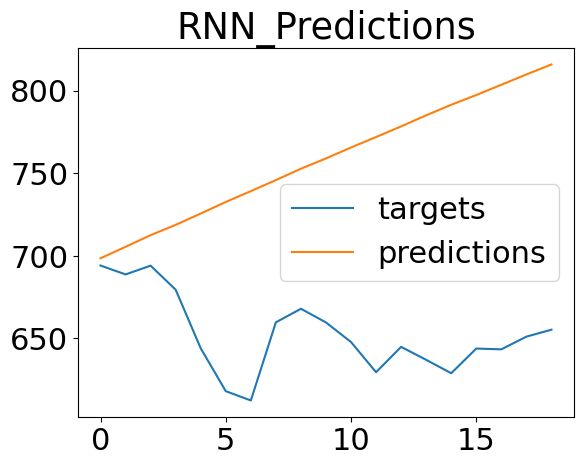

In [14]:
# Assuming you have a 1D time series data as a NumPy array
# Replace this with your actual data
data = series.values

# Reshape the data to be a column vector
data = data.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler=StandardScaler()
data_normalized = scaler.fit_transform(data)

# Define the sequence length (number of time steps for each input sequence)
sequence_length = 20

# Prepare sequences for input (X) and output (Y)
X, Y = [], []

for i in range(len(data_normalized) - sequence_length):
    # Input sequence
    x_sequence = data_normalized[i:i + sequence_length]
    # Output sequence (target)
    y_sequence = data_normalized[i + sequence_length]

    X.append(x_sequence)
    Y.append(y_sequence)

# Convert the lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into training and testing sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

# Create the LSTM model
model = Sequential()
model.add(SimpleRNN(units=80, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training set
model.fit(X_train, Y_train, epochs=100, batch_size=20, verbose=0)

# Use the trained model to make predictions on the test set
predictions = model.predict(X_test)

# Inference using predicted values as input for the next prediction
validation_target = Y_test
validation_predictions = []

last_x = X_test[0]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, sequence_length, 1))[0, 0]
    validation_predictions.append(p)
    last_x = np.roll(last_x, -1, axis=0)
    last_x[-1] = p

# Denormalize the predictions for better interpretation
validation_predictions = scaler.inverse_transform(np.array(validation_predictions).reshape(-1, 1))
validation_target = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))

plt.plot(validation_target[1:20], label="targets")
plt.plot(validation_predictions[1:20], label="predictions")
plt.title("RNN_Predictions")
plt.legend()
plt.savefig("RNN_Predictions.png")


# Evaluate the model
mse = root_mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')